In [1]:
import numpy as np

In [2]:
import csv
import sys

In [3]:
from PIL import Image
import random

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

data_path = '../../cosmology_aux_data_170429/labeled'

In [5]:
# chooses a random image to use as source for stars to add
def choose_img(num_images):
    random_img_idx = random.randint(0, num_images-1)
    src = cv2.imread(data_path + '/' + data[random_img_idx] + '.png')
    return src

In [44]:
def detect_stars(src):
    img = np.copy(src) #cv2.imread(img_path)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold and detect contours
    thresh = cv2.threshold(imgray, 20, 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh,
                                    cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    # print(len(contours))

    # filter contours by area
    min_area = 2
    filtered_contours = [c for c in contours
                             if cv2.contourArea(c) >= min_area]
    area_contours = [cv2.contourArea(c) for c in filtered_contours]
    # get bounding rectangles
    boundings = [cv2.boundingRect(c) for c in filtered_contours] # x,y,w,h
    #if (len(boundings) > 0):
        # print(boundings[0])

    # draw center location of blobs
    line_length = 8
    cross_color = (255, 0, 0)
    for i, c in enumerate(filtered_contours):
        line_length = max([boundings[i][2], boundings[i][3]])
        M = cv2.moments(c)
        x = int(M['m10']/M['m00'])
        y = int(M['m01']/M['m00'])
        cv2.line(img, (x-boundings[i][2], y), (x+boundings[i][2], y), cross_color, 2)
        cv2.line(img, (x, y-boundings[i][3]), (x, y+boundings[i][3]), cross_color, 2)
    
    # for checking, show image
    #plt.figure(figsize=(16, 16))
    #plt.title('ORB Interest Points')
    #plt.imshow(img); plt.show()
    
    return len(filtered_contours)

In [7]:
def add_random_star(dst, src):
    img = src
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold and detect contours
    thresh = cv2.threshold(imgray, 20, 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh,
                                    cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    # print(len(contours))

    # filter contours by area
    min_area = 2
    filtered_contours = [c for c in contours
                             if cv2.contourArea(c) >= min_area]
    area_contours = [cv2.contourArea(c) for c in filtered_contours]
    # get bounding rectangles
    boundings = [cv2.boundingRect(c) for c in filtered_contours] # (x,y,w,h)

    # add a star from the src image
    random_star = random.randint(0,len(boundings)-1)
    #print('src star # ' + repr(random_star))
    #print('src total stars: ' + repr(len(boundings)))
    rx = random.randint(0,src.shape[0]-1)
    ry = random.randint(0,src.shape[1]-1)
    xlength = min([rx+boundings[random_star][2], dst.shape[0]])
    ylength = min([ry+boundings[random_star][3], dst.shape[1]])
    dst[ry:ylength, rx:xlength] += \
        img[boundings[random_star][1]:boundings[random_star][1]+ylength-ry, 
            boundings[random_star][0]:boundings[random_star][0]+xlength-rx]
    
    #plt.figure(figsize=(16, 16))
    #plt.title('With new star')
    #plt.imshow(dst); plt.show()
    return dst

In [8]:
def find_num_stars(data):
    min_stars = sys.maxsize
    max_stars = 0
    
    for d in data:
        src = cv2.imread(data_path + '/'  + d + '.png')
        num_stars = detect_stars(src)
        if (num_stars > max_stars):
            max_stars = num_stars
        if (num_stars < min_stars):
            min_stars = num_stars
    
    return min_stars, max_stars

In [49]:
def generate_image(data, min_stars, max_stars):
    # initialize src and dst image
    src = choose_img(len(data))
    dst = np.zeros((src.shape[0], src.shape[1], src.shape[2]), np.uint8)
    
    # add noise
    cv2.randn(dst,10,5)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    dst = cv2.cvtColor(dst,cv2.COLOR_GRAY2RGB)
    
    # choose number of stars to add
    num_stars = random.randint(min_stars, max_stars)
    #print(repr(num_stars) + ' star(s) to add.')
    
    # add stars
    for i in range(num_stars):
        dst = add_random_star(dst, src)
        # get next random source image to take stars from
        src = choose_img(len(data)) 
    
    # make sure the highest value doesn't go over 254
    dst = np.clip(dst, 0, 254)
    
    # check image
    current_num_stars = detect_stars(dst) 
    #print('The generated image has ' + repr(current_num_stars)  + ' star(s).')
    
    # show image
    #plt.figure(figsize=(16, 16))
    #plt.title('With new star')
    #plt.imshow(dst); plt.show()
    return dst

In [47]:
# load in data
with open(data_path + '.csv') as csv_file:
    # 1201 lines, 1 header, 1000 cosmology images, 200 others
    csv_reader = csv.reader(csv_file, delimiter=',')
    header = next(csv_reader)
    data = list(csv_reader)
    
    data = [x[0] for x in data if x[1] != '0.0']
    # print(data)
    # print(len(data))

In [17]:
# initizalize number of stars
min_stars, max_stars = find_num_stars(data)
print(min_stars)
print(max_stars)

1
18


In [50]:
# generate images
for i in range(100):
    new_img = generate_image(data, min_stars, max_stars)
    cv2.imwrite( "./Images/" + repr(i) + ".jpg", new_img );

In [8]:
# test image to see how it looks
#img = Image.open('cosmology_aux_data_170429/labeled/' + data[1] + '.png')
#img.show()

254


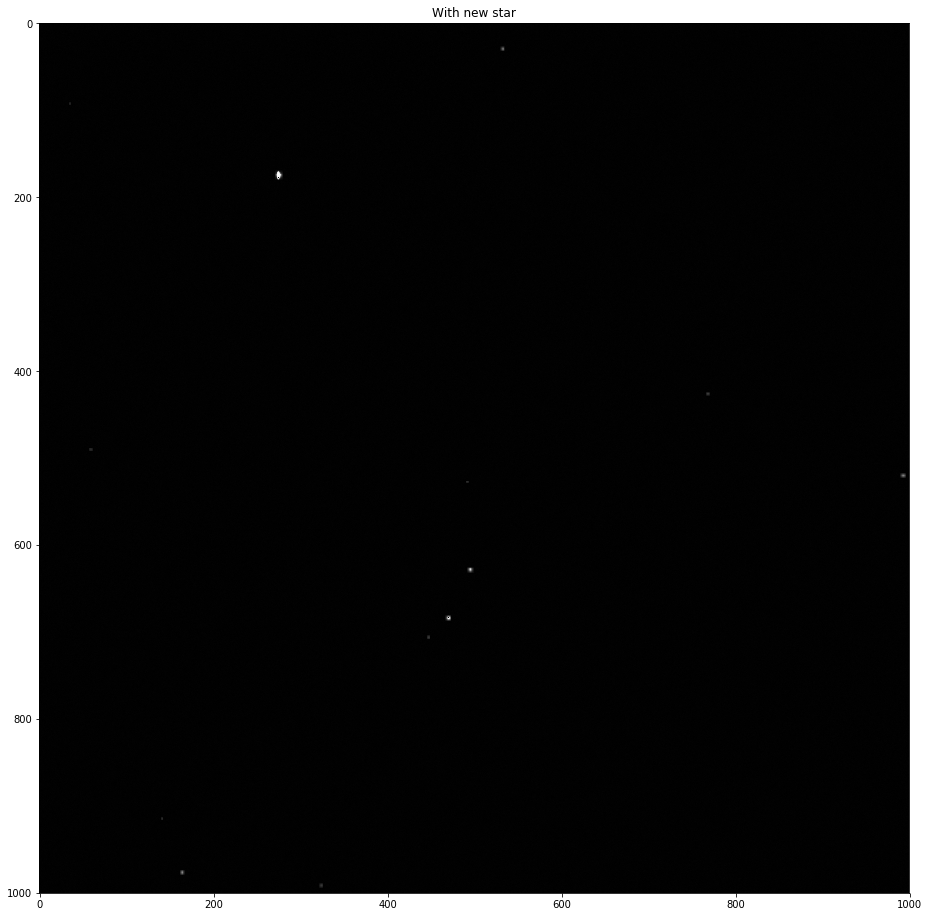

254


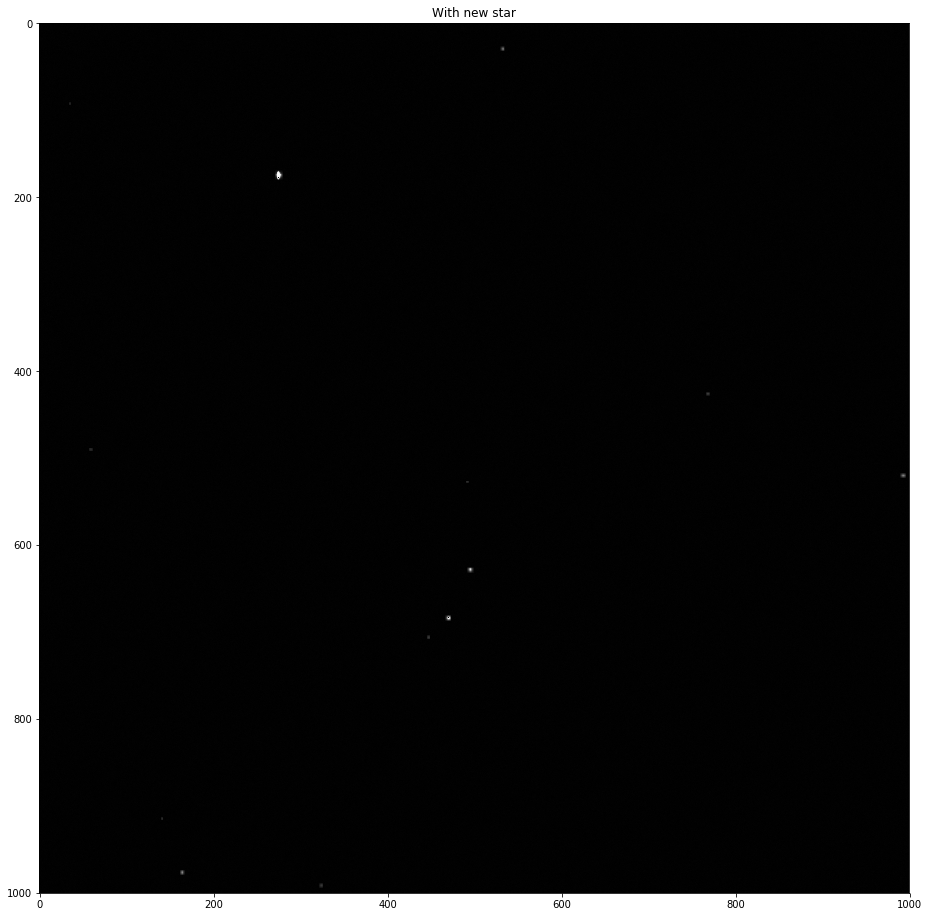

In [39]:
new_img = generate_image(data, min_stars, max_stars)
print(np.amax(new_img))
plt.figure(figsize=(16, 16))
plt.title('With new star')
plt.imshow(new_img); plt.show()
new_img = np.clip(new_img, 0, 254)
print(np.amax(new_img))
plt.figure(figsize=(16, 16))
plt.title('With new star')
plt.imshow(new_img); plt.show()

In [45]:
detect_stars(new_img)

15